In [1]:
import numpy as np  # 數值運算操作
import pandas as pd  # 資料處理操作
import tensorflow as tf  # 主要用於建立神經網路
import matplotlib.pyplot as plt  # 創建視覺化圖表，如圖形和曲線
import seaborn as sns  # 提供豐富的統計圖表功能
plt.rcParams['figure.figsize'] = (20, 20)  # 設定Matplotlib創建的圖表的預設大小

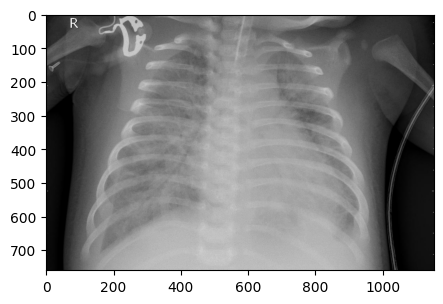

In [2]:
from glob import glob  # 用於獲取文件路徑列表
path_train = "./chest_xray/train"  # 設定訓練數據集的路徑
img = glob(path_train + "/PNEUMONIA/*.jpeg")  # 獲取訓練數據集中肺炎文件夾中JPEG文件的路徑列表

img = np.asarray(plt.imread(img[0]))  # 讀取上述列表中的第一個圖片文件
plt.figure(figsize=(5, 5))  # 設定圖表大小為5 x 5英寸
plt.imshow(img,cmap='gray')  # 顯示圖片

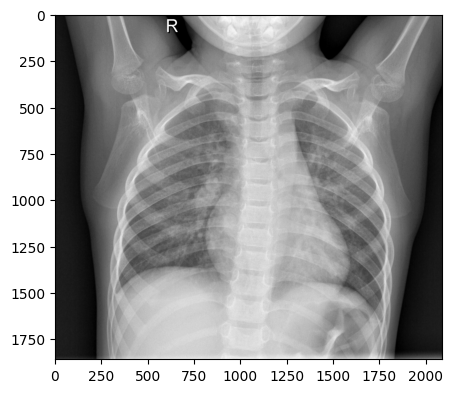

In [3]:
img = glob(path_train + "/NORMAL/*.jpeg")  # 創建訓練數據集中正常文件夾中JPEG文件的路徑列表
img = np.asarray(plt.imread(img[0]))  # 讀取上述列表中的第一個圖片文件
plt.figure(figsize=(5, 5))  # 設定圖表大小為5 x 5英寸
plt.imshow(img,cmap='gray')  # 顯示圖片

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# load_img 將任何圖片文件轉換為 PIL（Python Imaging Library） 圖片
# img_to_array 將任何 PIL/Keras 圖片張量轉換為 NumPy 陣列

In [5]:
from tensorflow.keras.models import Sequential, Model
# Sequential 確保模型逐步構建，逐層添加


In [6]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization
# Conv2D: 2D卷積層
# Dense: 全連接網路，每個神經元與上一層和下一層的每個神經元相連接
# Flatten: 將多維輸入張量轉換為一維張量
# Input: 輸入層
# MaxPooling2D: 最大池化操作，將矩陣的大小減小
# Dropout: 一種防止過擬合的方法，訓練過程中忽略一些隨機神經元
# BatchNormalization: 正規化和縮放輸入

In [7]:
img_size = 150
batch_size = 32

# traingen 配置訓練數據生成器
traingen = ImageDataGenerator(
    rescale=1/255.,  # 將像素值重新縮放到 0 到 1 的範圍
    brightness_range=[0.2, 1.2],  # 隨機設置圖片的亮度在給定範圍內
    width_shift_range=0.1,  # 隨機水平平移圖片的範圍
    height_shift_range=0.1,  # 隨機垂直平移圖片的範圍
    horizontal_flip=True  # 隨機水平翻轉圖片
)

# testgen 配置測試數據生成器
testgen = ImageDataGenerator(rescale=1/255.)

# valgen 配置驗證數據生成器
valgen = ImageDataGenerator(
    rescale=1/255.,  # 將像素值重新縮放到 0 到 1 的範圍
    brightness_range=[0.2, 1.2],  # 隨機設置圖片的亮度在給定範圍內
    width_shift_range=0.1,  # 隨機水平平移圖片的範圍
    height_shift_range=0.1,  # 隨機垂直平移圖片的範圍
    horizontal_flip=True  # 隨機水平翻轉圖片
)


In [8]:
# 訓練數據生成器
traindata = traingen.flow_from_directory(
    './chest_xray/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',  # 二元分類
    color_mode='grayscale'  # 讀取灰度圖像
)

# 測試數據生成器
testdata = testgen.flow_from_directory(
    './chest_xray/test',
    shuffle=False,
    batch_size=batch_size,
    target_size=(img_size, img_size),
    class_mode='binary',  # 二元分類
    color_mode='grayscale'  # 讀取灰度圖像
)

# 驗證數據生成器
valdata = valgen.flow_from_directory(
    './chest_xray/val',
    shuffle=False,
    batch_size=batch_size,
    target_size=(img_size, img_size),
    class_mode='binary',  # 二元分類
    color_mode='grayscale'  # 讀取灰度圖像
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


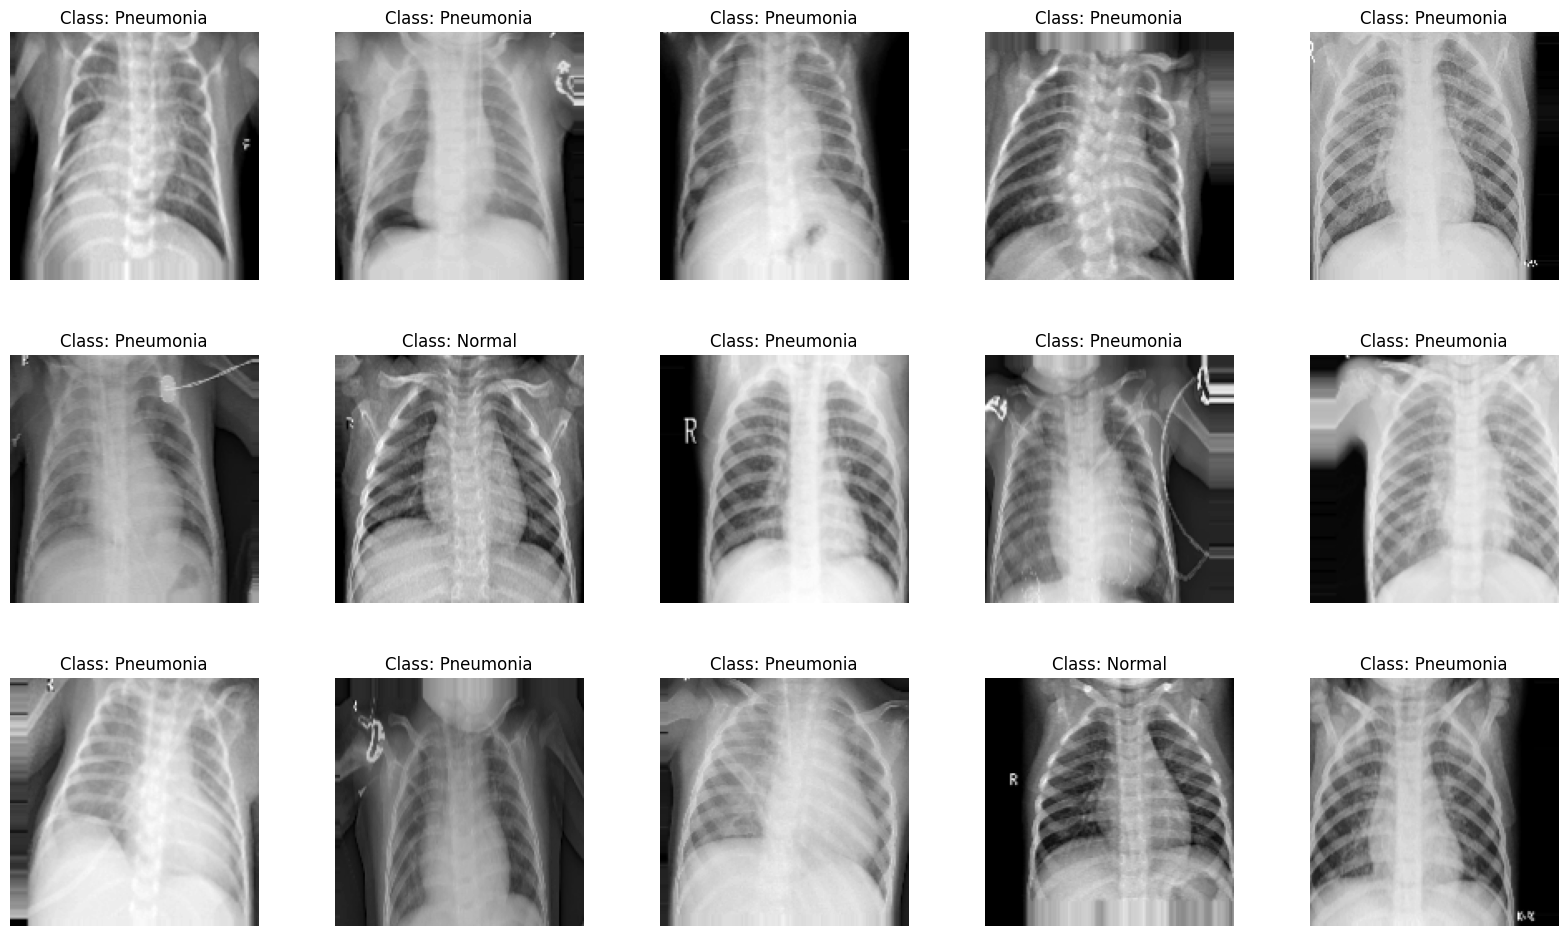

In [9]:
labels = ['Normal', 'Pneumonia']  # 二元分類的標籤
samples = traindata.__next__()  # 從訓練數據生成器中獲取下一批標籤和圖片

images = samples[0]  # 包含一批圖片
target = samples[1]  # 包含相應的標籤，0 表示正常，1 表示肺炎

for i in range(15):  # 批次中的前 15 張圖片
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i],cmap='gray')
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [10]:
# 創建 DataFrame 以顯示訓練數據的類別分佈
df=pd.DataFrame(traindata.classes)
df.value_counts()

1    3875
0    1341
Name: count, dtype: int64

In [11]:
# 創建 DataFrame 以顯示驗證數據的類別分佈
df=pd.DataFrame(valdata.classes)
df.value_counts()

0    8
1    8
Name: count, dtype: int64

In [12]:
# 創建 DataFrame 以顯示測試數據的類別分佈
df=pd.DataFrame(testdata.classes)
df.value_counts()

1    390
0    234
Name: count, dtype: int64

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model = Sequential()  # 逐層建立神經網路

# 第一層卷積層
model.add(Conv2D(32, (2, 2), input_shape=(img_size, img_size, 1), activation="relu", padding='same', strides=1))
# 32個2x2的過濾器，輸入圖片的大小為指定大小和灰度，使用relu激活函數，步幅為1
model.add(MaxPooling2D())
# 池化和縮小維度

# 第二層卷積層
model.add(Conv2D(64, (2, 2), strides=2, activation="relu", padding="same"))
# 64個2x2的過濾器，更大的步幅為2
model.add(MaxPooling2D())

# 第三層卷積層
model.add(Conv2D(128, (2, 2), strides=1, activation="relu", padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
# 將前一層展平，將多維圖片轉換為完整的單一維度

model.add(Dense(128, activation="relu"))
# 具有128個神經元的全連接網路

model.add(Dense(1, activation='sigmoid'))
# 最終輸出層只有一個神經元，滿足二元分類的需求


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 128)         0

In [15]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# 使用adam優化器，binary_crossentropy損失函數，並以準確度為指標評估模型
# adam是一種優秀的優化器，binary_crossentropy主要用於二元輸出，accuracy是我們評估模型的標準

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
# save_best_only 為 True 時，只有在驗證損失改善時才保存模型權重
# save_weights_only 為 False 時，保存整個模型；為 True 時，僅保存模型權重

In [17]:
history = model.fit(traindata, validation_data=valdata, epochs=50, callbacks=[checkpoint])
# 回調是上面定義的checkpoint
# history 是一個對象，包含訓練過程中的所有數據，如 val_loss 和 accuracy，每個 epoch 都會更新

Epoch 1/50


163/163 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8133
Epoch 1: val_loss improved from inf to 0.57378, saving model to model_cnn.h5
163/163 [==============================] - 31s 187ms/step - loss: 0.4092 - accuracy: 0.8133 - val_loss: 0.5738 - val_accuracy: 0.7500
Epoch 2/50


C:\Users\U\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - ETA: 0s - loss: 0.2463 - accuracy: 0.8957
Epoch 2: val_loss did not improve from 0.57378
163/163 [==============================] - 30s 182ms/step - loss: 0.2463 - accuracy: 0.8957 - val_loss: 0.6277 - val_accuracy: 0.8125
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9187
Epoch 3: val_loss did not improve from 0.57378
163/163 [==============================] - 32s 198ms/step - loss: 0.2097 - accuracy: 0.9187 - val_loss: 0.8961 - val_accuracy: 0.7500
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9218
Epoch 4: val_loss did not improve from 0.57378
163/163 [==============================] - 31s 191ms/step - loss: 0.2017 - accuracy: 0.9218 - val_loss: 1.3377 - val_accuracy: 0.6875
Epoch 5/50
163/163 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9346
Epoch 5: val_loss did not improve from 0.57378
163/163 [============================

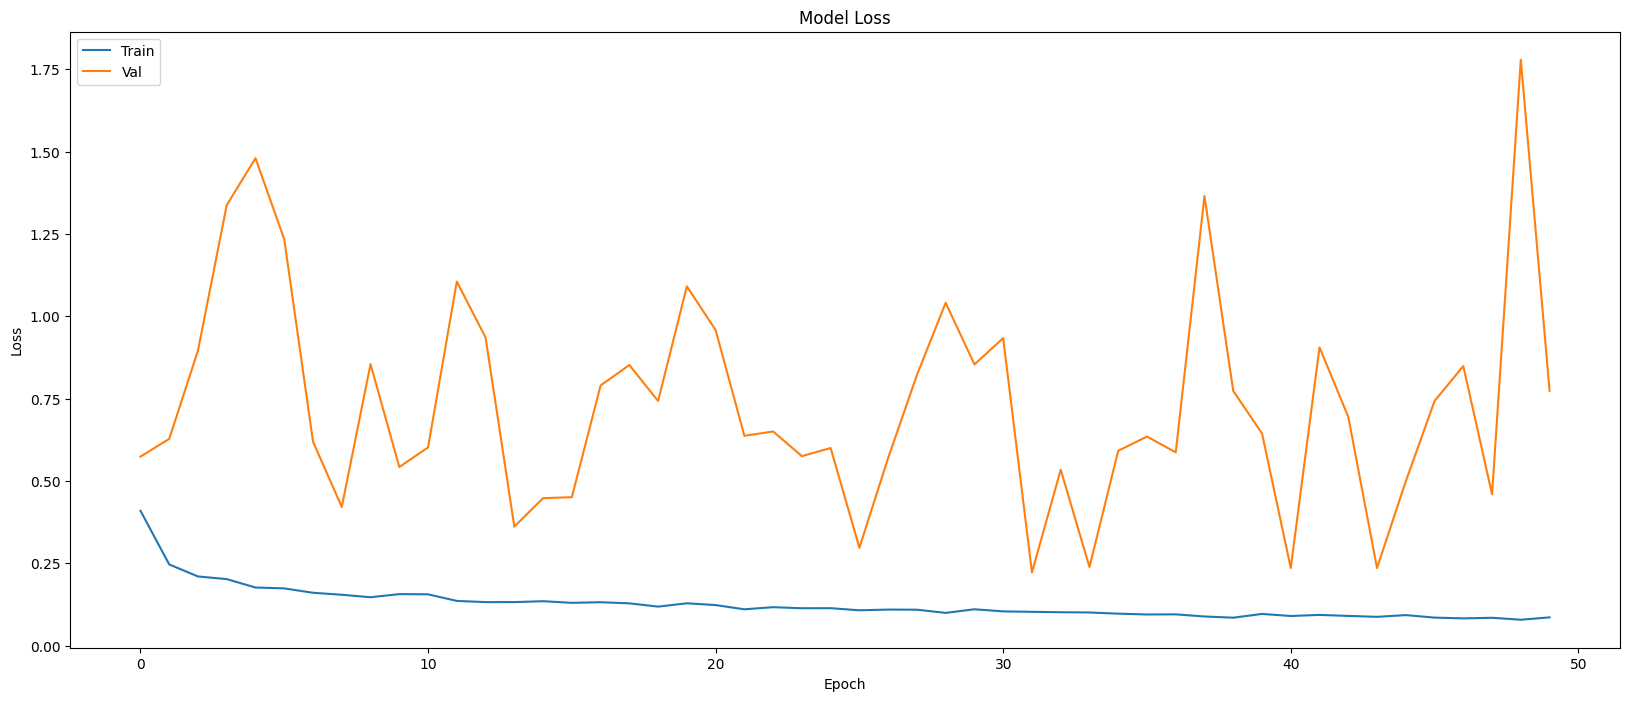

In [18]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
# 繪製每個 epoch 的訓練損失

plt.plot(history.history['val_loss'])
# 繪製每個 epoch 的驗證損失

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


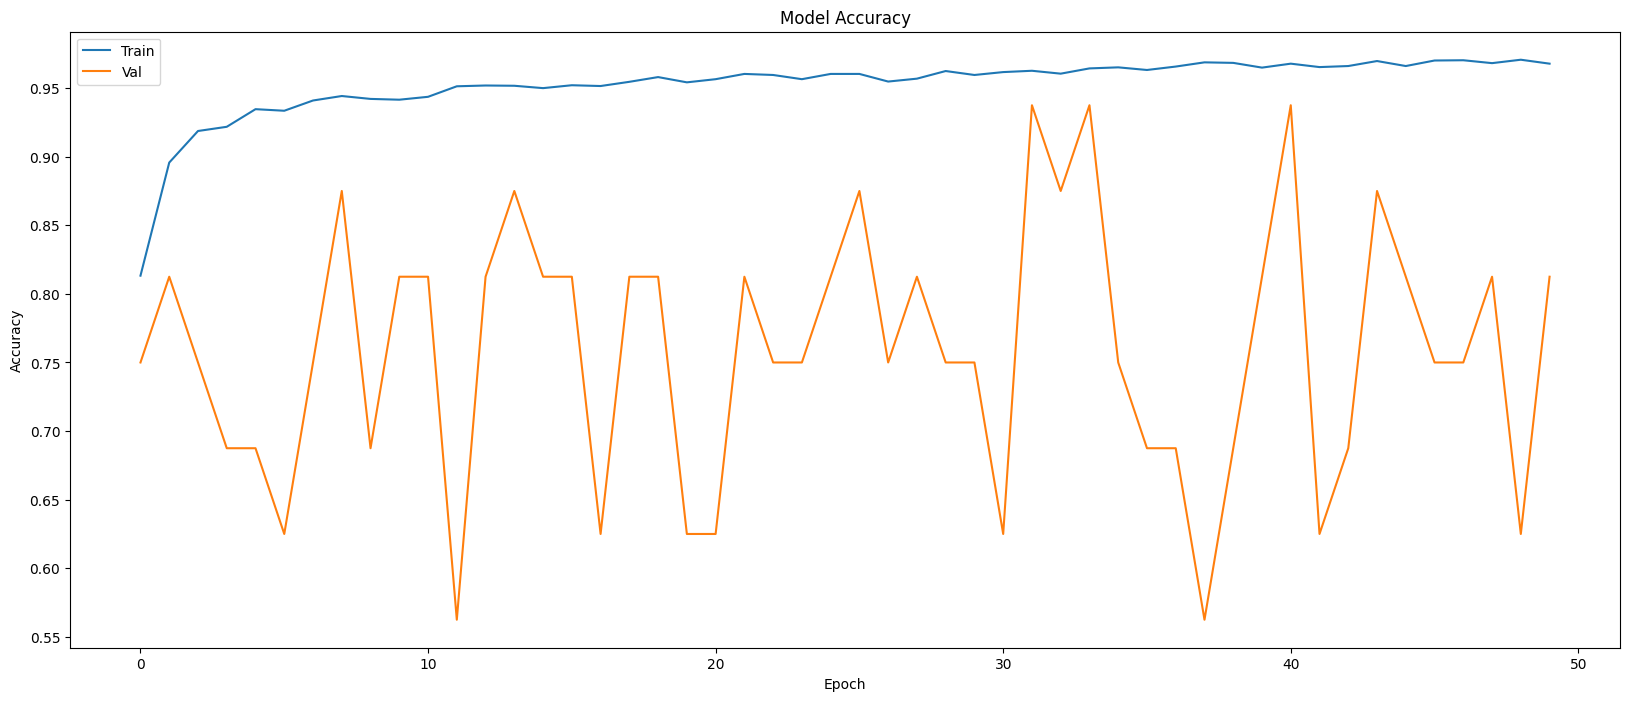

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
# 繪製每個 epoch 的訓練準確度

plt.plot(history.history['val_accuracy'])
# 繪製每個 epoch 的驗證準確度

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [20]:
y_test = valdata.classes
# y_test 包含驗證數據集中所有樣本的二元標籤

y_pred = model.predict(valdata)
# 使用訓練好的模型對驗證數據集進行預測，獲得每個樣本的預測概率

y_pred_probs = y_pred.copy()
# 儲存預測概率的副本

y_pred[y_pred > 0.5] = 1
# 使預測概率大於0.5的樣本的預測結果為1

y_pred[y_pred < 0.5] = 0
# 使預測概率小於0.5的樣本的預測結果為0

1/1 [==============================] - 0s 204ms/step


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print(classification_report(y_test, y_pred, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.50      0.67         8
   Pneumonia       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



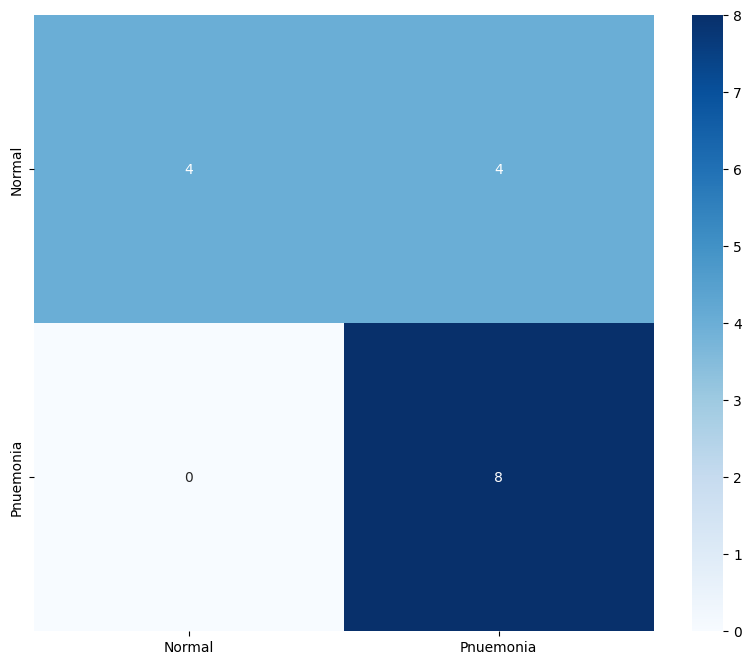

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

20/20 [==============================] - 2s 91ms/step


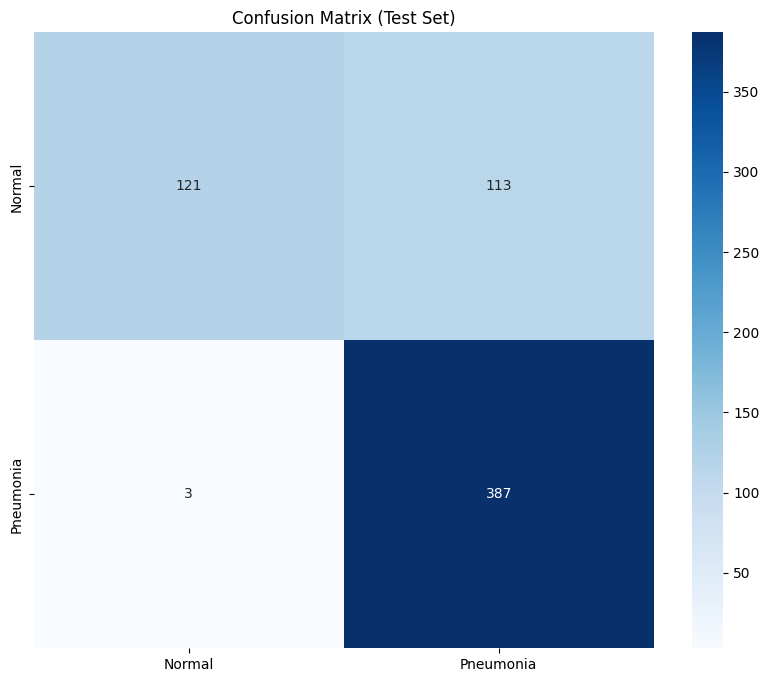

In [29]:
# y_test 包含了原始測試數據集中所有樣本的二元標籤
y_test = testdata.classes

# 使用訓練好的模型對測試數據集進行預測，獲得每個樣本的預測概率
y_pred = model.predict(testdata)

# 將預測概率轉換為二元分類預測
y_pred_binary = (y_pred > 0.5).astype(int)

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# 繪製熱力圖
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='.3g', xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'], cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [24]:
y_test = testdata.classes
# y_test 包含了原始測試數據集中所有樣本的二元標籤

y_pred = model.predict(testdata)
# 使用訓練好的模型對測試數據集進行預測，獲得每個樣本的預測概率

y_pred_probs = y_pred.copy()
# 創建預測概率的副本

20/20 [==============================] - 2s 98ms/step


In [25]:
y_pred[y_pred > 0.5] = 1
# 使預測概率大於0.5的樣本的預測結果設為1，即二元分類的正類別

y_pred[y_pred < 0.5] = 0
# 使預測概率小於0.5的樣本的預測結果設為0，即二元分類的負類別


In [26]:
print(classification_report(y_test,y_pred,target_names = ['Normal','Pnuemonia']))

              precision    recall  f1-score   support

      Normal       0.98      0.52      0.68       234
   Pnuemonia       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



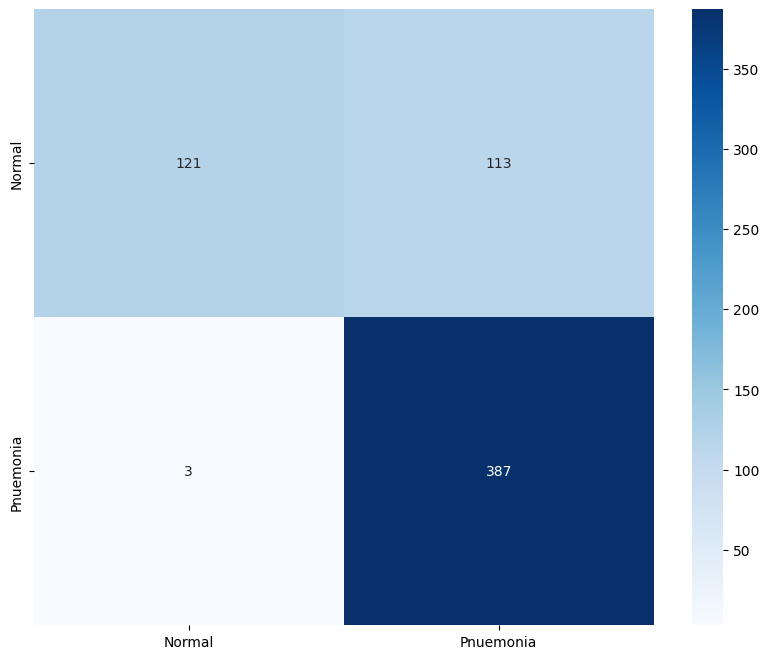

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

1/1 [==============================] - 0s 114ms/step
準確度（Accuracy）: 0.8125
精確度（Precision）: 0.7273
召回率（Recall）: 1.0000
特異度: 0.6250
F1 分數（F1 Score）: 0.8421
AUC-ROC 曲線下面積: 0.9531
AUC-PR 曲線下面積: 0.9569


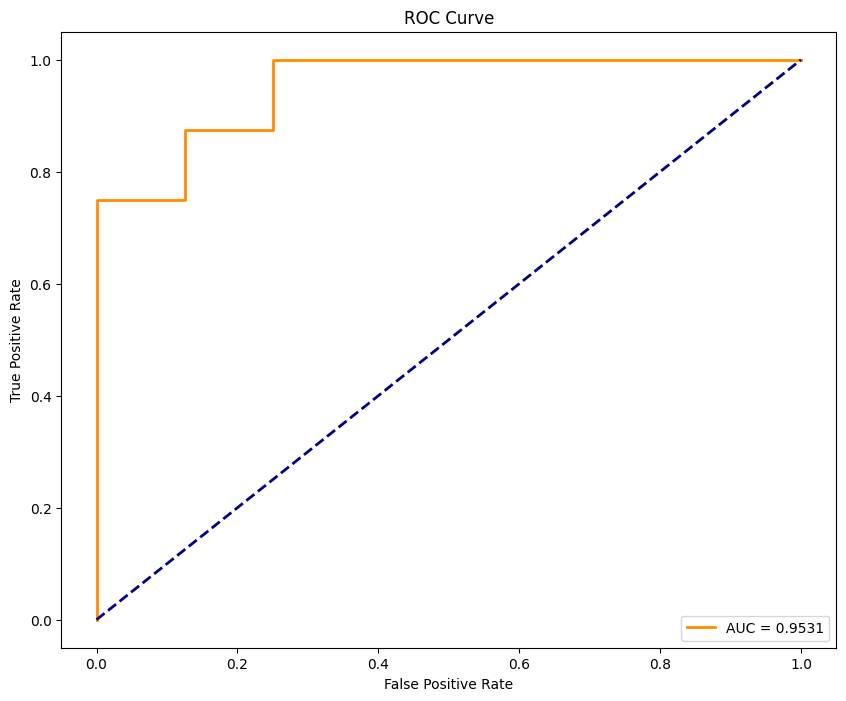

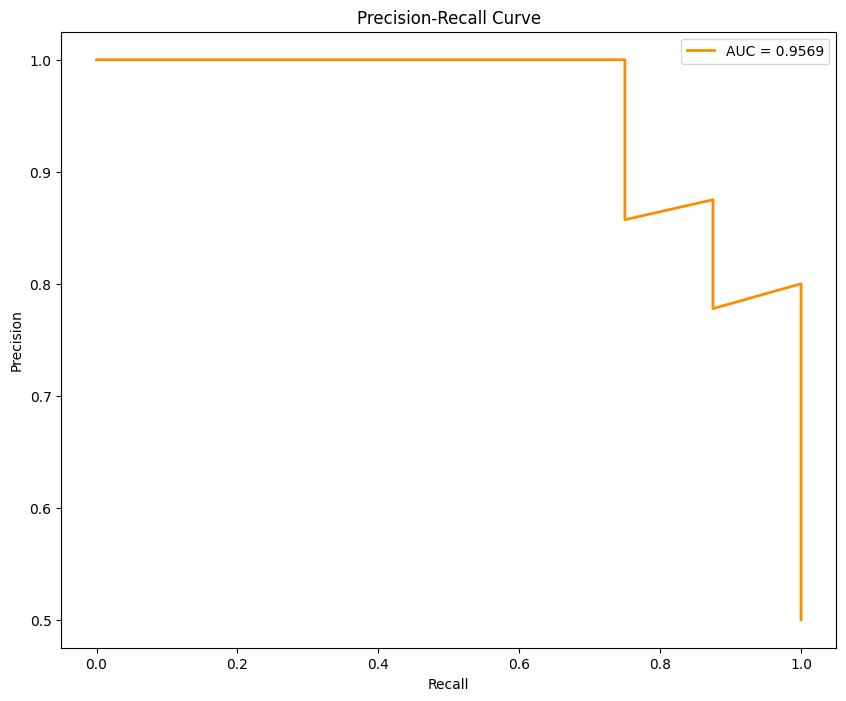

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

# 預測樣本的概率
y_pred_probs = model.predict(valdata)

# 將概率轉換為二元分類預測
y_pred = (y_pred_probs > 0.5).astype(int)

# 真實標籤
y_test = valdata.classes

# 計算準確度
accuracy = accuracy_score(y_test, y_pred)
print(f'準確度（Accuracy）: {accuracy:.4f}')

# 計算精確度
precision = precision_score(y_test, y_pred)
print(f'精確度（Precision）: {precision:.4f}')

# 計算召回率（Recall）或靈敏度（Sensitivity）
recall = recall_score(y_test, y_pred)
print(f'召回率（Recall）: {recall:.4f}')

# 計算特異度
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f'特異度: {specificity:.4f}')

# 計算F1分數（F1 Score）
f1 = f1_score(y_test, y_pred)
print(f'F1 分數（F1 Score）: {f1:.4f}')

# 計算AUC-ROC曲線下面積
auc_roc = roc_auc_score(y_test, y_pred_probs)
print(f'AUC-ROC 曲線下面積: {auc_roc:.4f}')

# 計算ROC曲線
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# 計算AUC-PR曲線下面積
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(recall, precision)
print(f'AUC-PR 曲線下面積: {auc_pr:.4f}')

# 繪製ROC曲線
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 繪製AUC-PR曲線
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC = {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
